# Maximum Logit Score / Maximum Softmax Probability

This notebook aims at evaluating the **MLS** and **MSP methods**.

These methods return an OOD score based on the maximum value of the output logits or softmax activations.

Here, we focus on a toy convolutional network trained on MNIST[0-4] and a ResNet20 model trained on CIFAR-10, respectively challenged on MNIST[5-9] and SVHN OOD datasets.

**References**
- **MLS**: [Open-Set Recognition: a Good Closed-Set Classifier is All You Need?](http://arxiv.org/abs/2110.06207), ICLR 2022.
- **MSP**: [A Baseline for Detecting Misclassified and Out-of-Distribution Examples in Neural Networks](http://arxiv.org/abs/1610.02136), ICLR 2017.

### Imports

In [3]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

os.environ["KERAS_BACKEND"] = "tensorflow"  # "tensorflow" or "torch" or "jax"

from IPython.display import clear_output
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
try:
    from torchvision import transforms
except:
    pass
import keras

if keras.config.backend() == "torch":
    keras.backend.set_image_data_format('channels_first')
else:
    keras.backend.set_image_data_format('channels_last')

from oodeel.methods import MLS, DKNN
from oodeel.eval.metrics import bench_metrics
from oodeel.eval.plots import plot_ood_scores, plot_roc_curve, plot_2D_features
from oodeel.datasets import load_data_handler


2025-04-28 16:17:47.050978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745849867.062574 4014625 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745849867.066120 4014625 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745849867.075316 4014625 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745849867.075332 4014625 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745849867.075333 4014625 computation_placer.cc:177] computation placer alr

Note that models are saved at *~/.oodeel/saved_models* and data is supposed to be found
at *~/.oodeel/datasets* by default. Change the following cell for a custom path.

In [4]:
model_path = os.path.expanduser("~/") + ".oodeel/saved_models"
data_path = os.path.expanduser("~/") + ".oodeel/datasets"
os.makedirs(model_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

## Second exp: CIFAR-10 vs SVHN

For this second experiment, we oppose **CIFAR-10** (in-distribution dataset) to **SVHN** (out-of-distribution dataset).


### Data loading

* In-distribution data: CIFAR-10 
* Out-of-distribution data: SVHN

In [5]:
# === Load ID and OOD data ===
batch_size = 128

data_handler = load_data_handler("keras3")

if keras.config.backend() == "torch":
    ds_fit = data_handler.load_dataset(
        "CIFAR10", load_kwargs={"root": data_path, "train": True, "download": True}
    )
    ds_in = data_handler.load_dataset(
        "CIFAR10", load_kwargs={"root": data_path, "train": False, "download": True}
    )
    ds_out = data_handler.load_dataset(
        "SVHN", load_kwargs={"root": data_path, "split": "test", "download": True}
    )

    def preprocess_fn(inputs):
        inputs["input"] = inputs["input"].float() / 255.0
        mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
        inputs["input"] = transforms.Normalize(mean, std)(inputs["input"])
        return inputs

    ds_fit = data_handler.prepare(
        ds_fit, batch_size, preprocess_fn, columns=["input", "label"]
    )
    ds_in = data_handler.prepare(
        ds_in, batch_size, preprocess_fn, columns=["input", "label"]
    )
    ds_out = data_handler.prepare(
        ds_out, batch_size, preprocess_fn, columns=["input", "label"]
    )

elif keras.config.backend() == "tensorflow":
    data_handler = load_data_handler("tensorflow")

    # 1a- Load in-distribution dataset: CIFAR-10
    ds_fit = data_handler.load_dataset("cifar10", load_kwargs={"split": "train"})
    ds_in = data_handler.load_dataset("cifar10", load_kwargs={"split": "test"})

    # 1b- Load out-of-distribution dataset: SVHN
    ds_out = data_handler.load_dataset("svhn_cropped", load_kwargs={"split": "test"})

    def preprocess_fn(inputs):
        inputs["image"] /= 255
        return inputs

    ds_fit = data_handler.prepare(
        ds_fit, batch_size, preprocess_fn, columns=["image", "label"]
    )
    ds_in = data_handler.prepare(
        ds_in, batch_size, preprocess_fn, columns=["image", "label"]
    )
    ds_out = data_handler.prepare(
        ds_out, batch_size, preprocess_fn, columns=["image", "label"]
    )

elif keras.config.backend() == "jax":
    raise NotImplementedError("JAX backend is not yet supported for this example.")

clear_output()

In [6]:
for batch in ds_fit:
    break
print(batch[0].shape)
print(batch[1].shape)

(128, 32, 32, 3)
(128,)


### Model training

The model is trained.

In [7]:
# === load model ===
# resnet20 pretrained on CIFAR-10
input_shape = (3, 32, 32) if keras.config.backend() == "torch" else (32, 32, 3)
model = keras.Sequential(
    [
        keras.layers.Conv2D(32, 3, input_shape=input_shape, padding="same"),
        keras.layers.ReLU(),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(64, 3, padding="same"),
        keras.layers.ReLU(),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(64, 3, padding="same"),
        keras.layers.ReLU(),
        keras.layers.Flatten(),
        keras.layers.Dense(64),
        keras.layers.ReLU(),
        keras.layers.Dense(10),
    ]
)

model = keras.Sequential(
    [
        keras.layers.Conv2D(32, 3, input_shape=input_shape, padding="same"),
        keras.layers.ReLU(),
        keras.layers.Conv2D(64, 3, input_shape=input_shape, padding="same"),
        keras.layers.ReLU(),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(64, 3, padding="same"),
        keras.layers.ReLU(),
        keras.layers.Conv2D(128, 3, padding="same"),
        keras.layers.ReLU(),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(128),
        keras.layers.ReLU(),
        keras.layers.Dense(10),
    ]
)

model.summary()

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"],
)

try:
    raise
    model.load_weights(
        os.path.join(model_path, f"convnet_cifar10_keras3_{keras.config.backend()}.h5")
    )
except:
    model.fit(ds_fit, epochs=5, validation_data=ds_in)
    model.save(
        os.path.join(model_path, f"convnet_cifar10_keras3_{keras.config.backend()}.h5")
    )

# evaluate model
model.evaluate(ds_in)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,180,170 (4.50 MB)

 Trainable params: 1,180,170 (4.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


I0000 00:00:1745849882.117233 4014834 service.cc:152] XLA service 0x7fb6600021d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745849882.117250 4014834 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
I0000 00:00:1745849882.522352 4014834 cuda_dnn.cc:529] Loaded cuDNN version 90300


 13/391 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1468 - loss: 2.2858 

I0000 00:00:1745849884.567965 4014834 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.3711 - loss: 1.7277 - val_accuracy: 0.5944 - val_loss: 1.1156
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6324 - loss: 1.0498 - val_accuracy: 0.6820 - val_loss: 0.9105
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7150 - loss: 0.8244 - val_accuracy: 0.7150 - val_loss: 0.8122
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7690 - loss: 0.6792 - val_accuracy: 0.7403 - val_loss: 0.7688
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8059 - loss: 0.5725 - val_accuracy: 0.7338 - val_loss: 0.8098


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7401 - loss: 0.7968


[0.8097630143165588, 0.7337999939918518]

In [21]:
# import keras_hub


# backbone = keras_hub.models.ResNetBackbone(
#     input_conv_filters=[64],
#     input_conv_kernel_sizes=[3],
#     stackwise_num_filters=[64, 64, 64],
#     stackwise_num_blocks=[2, 2, 2],
#     stackwise_num_strides=[1, 2, 1],
#     block_type="basic_block",
#     use_pre_activation=True,
#     pooling="avg",
#     image_shape=input_shape,
# )

# model = keras_hub.models.ResNetImageClassifier(
#     backbone,
#     num_classes=10,
#     preprocessor=None,
#     pooling="avg",
#     activation=None,
#     dropout=0.0,
#     head_dtype=None,
# )

# model.summary()

# model.compile(
#     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     optimizer=keras.optimizers.Adam(learning_rate=1e-3),
#     metrics=["accuracy"],
# )

# model.fit(ds_fit, epochs=5, validation_data=ds_in)

Model: "res_net_image_classifier_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                       ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)                   │ (None, 32, 32, 3)                  │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ res_net_backbone_4 (ResNetBackbone)           │ (None, 4, 4, 64)                   │             455,616 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ pooler (GlobalAveragePooling2D)               │ (None, 64)                         │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ output_dropout (Dropout)                      │ (None, 64)                         │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ predictions (Dense)                           │ (None, 10)                         │                 650 │
└───────────────────────────────────────────────┴────────────────────────────────────┴─────────────────────┘

 Total params: 456,266 (1.74 MB)

 Trainable params: 454,602 (1.73 MB)

 Non-trainable params: 1,664 (6.50 KB)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.4309 - loss: 1.5761 - val_accuracy: 0.5415 - val_loss: 1.3106
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6345 - loss: 1.0387 - val_accuracy: 0.6510 - val_loss: 0.9996
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7064 - loss: 0.8408 - val_accuracy: 0.6599 - val_loss: 1.0056
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7551 - loss: 0.7122 - val_accuracy: 0.6559 - val_loss: 1.0894
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7909 - loss: 0.6108 - val_accuracy: 0.6066 - val_loss: 1.4160



=== Penultimate features viz ===


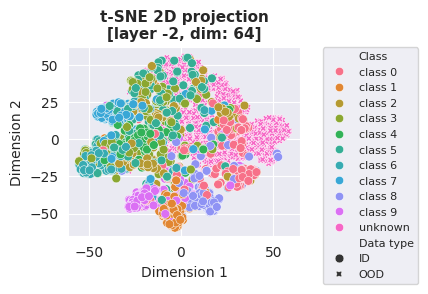

In [22]:
# penultimate features 2d visualization
print("\n=== Penultimate features viz ===")
plt.figure(figsize=(4.5, 3))
plot_2D_features(
    model=model,
    in_dataset=ds_in,
    out_dataset=ds_out,
    output_layer_id=-2,
)
plt.tight_layout()
plt.show()

In [9]:
# from oodeel.extractor.keras3_feature_extractor import Keras3FeatureExtractor

# extractor = Keras3FeatureExtractor(model, feature_layers_id=-2)

# import torch

# for i, batch in enumerate(ds_fit):
#     print("Batch:", i + 1)
#     out = extractor.predict_tensor(batch[0])
#     mem = torch.cuda.mem_get_info()
#     print("Memory usage: ", (mem[1] - mem[0]) / 1e6, "MB")

### MLS score

We now fit an MLS detector with CIFAR-10 train dataset, and compare OOD scores returned for CIFAR-10 (ID) and SVHN (OOD) test datasets.  

=== Metrics ===
auroc      0.752091
fpr95tpr   0.590900

=== Plots ===


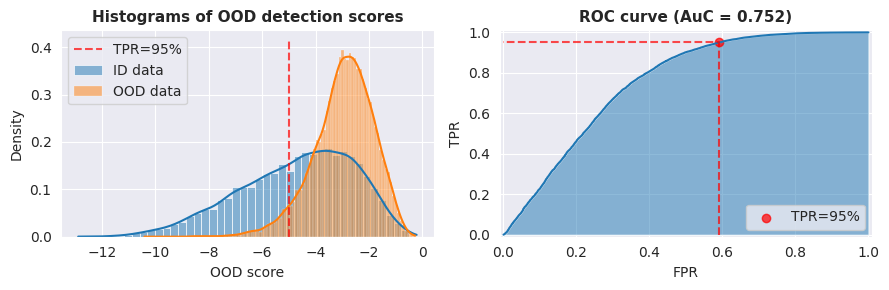

In [23]:
from oodeel.methods import MLS, DKNN, Mahalanobis

# === mls scores ===
mls = MLS()
mls.fit(model)
scores_in, _ = mls.score(ds_in)
scores_out, _ = mls.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

=== Metrics ===
auroc      0.761196
fpr95tpr   0.594400

=== Plots ===


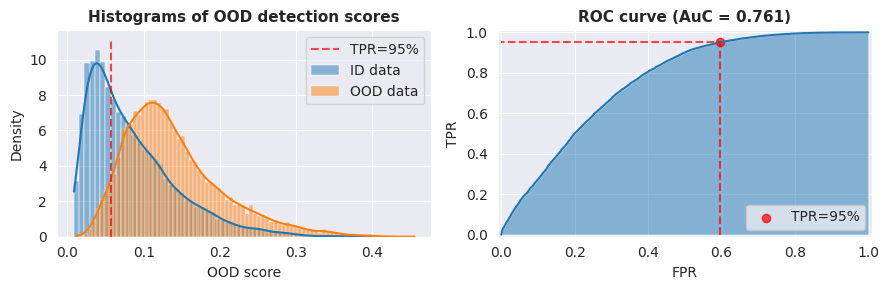

In [24]:
# === DKNN scores ===
dknn = DKNN()
dknn.fit(model, ds_fit, feature_layers_id=-2)
scores_in, _ = dknn.score(ds_in)
scores_out, _ = dknn.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

=== Metrics ===
auroc      0.698803
fpr95tpr   0.817700

=== Plots ===


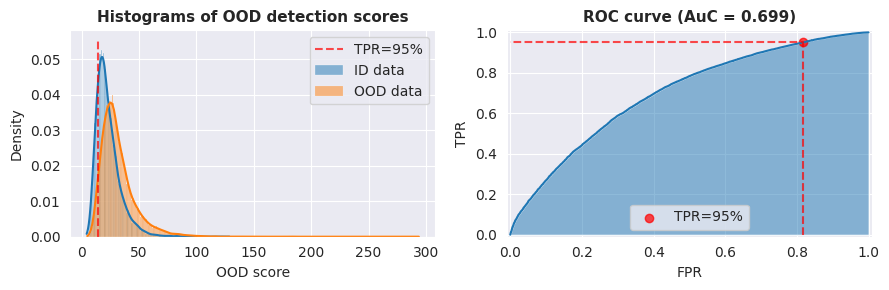

In [25]:
# === Mahalanobis scores ===
maha = Mahalanobis(eps=0.002)
maha.fit(model, ds_fit, feature_layers_id=-2)
scores_in, _ = maha.score(ds_in)
scores_out, _ = maha.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

### MSP score

Using the softmax activations instead, we get the MSP scores for CIFAR-10 (ID) and SVHN (OOD) test datasets.

=== Metrics ===
auroc      0.797215
fpr95tpr   0.468200

=== Plots ===


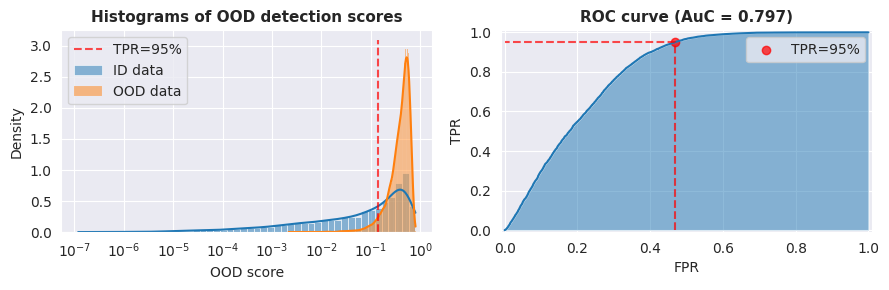

In [13]:
# === msp scores ===
msp = MLS(output_activation="softmax")
msp.fit(model)
scores_in, _ = msp.score(ds_in)
scores_out, _ = msp.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# Normalize scores for a better hist visualization
minim = np.min([np.min(scores_in), np.min(scores_out)])
scores_in_ = scores_in - 2 * minim + np.min(scores_in[np.where(scores_in != minim)])
scores_out_ = scores_out - 2 * minim + np.min(scores_in[np.where(scores_in != minim)])

# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in_, scores_out_, log_scale=True)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()